<img src='https://wallpaperaccess.com/full/471490.jpg' />

# Greek Hedging

W tym notebooku zaprezentujemy:
* Jaka jest intuicja za greckimi parametrami?
* Co stoi za zmianą cen instrumentu pochodnego?
* Jak możemy użyć tej wiedzy do zabezpieczenia pozycji?

In [24]:
!pip install mibian
!pip install yfinance
!pip install dash
!pip install jupyter-dash
!pip install --upgrade matplotlib

     |████████████████████████████████| 7.3 MB 5.2 MB/s 
     |████████████████████████████████| 26.5 MB 60.5 MB/s 
     |████████████████████████████████| 357 kB 62.6 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=491a68dbe90bdafd1d69aed606ebba37e2c17d892422a662b48cc8ff25abce27
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=6bfe3a1db936d90bd36cbc78765df4cb1647ed85ae5ce817cd35b9027ab3a820
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3911 sha256=4135f9c80375d7b749fc76cfd23293b8b3370f02a7e758409b985955bdab4182
  Stored in directory: /root/.cache/pip/wheels/85/5d/4e/7c276b57992951dbe770bf5caad6448d0539c510663ae

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import scipy.stats as sc
from scipy.stats import norm
from IPython.core.debugger import Pdb
from IPython.display import HTML
import mibian
import yfinance as yf
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc
from dash import html
import plotly.express as px
from jupyter_dash import JupyterDash
import pandas as pd

plt.style.use('seaborn')
colorscale = 'rdbu'

%matplotlib notebook

### Geometryczny ruch Browna

Jako model cen akcji przyjmujemy GBM, poniżej przykładowa funkcja generująca wybraną liczbę trajektorii przy zadanych parametrach

In [2]:
def gbm(S0: float, r: float, sigma: float, T: float, time_steps: int, n_paths: int, 
        random_generator = sc.norm(0, 1)):
    """
    Generate Geometric Brownian Motion paths
    :param S0: float, starting price
    :param r: float, risk free rate
    :param sigma: float, volatility
    :param T: float, time horizon
    :param time_steps: int, how many subintervals include from 0 to T
    :param n_paths: int, how many paths to simulate
    :param random_generator: distribution family from which to draw random increments
    :return: paths: ndarray, simulated paths
    """
    
    dt = float(T) / time_steps
    paths = np.zeros((time_steps + 1, n_paths), np.float64)
    paths[0] = S0
    for t in range(1, time_steps + 1):
        rand = random_generator.rvs(size = n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

def run_animation(t: np.array, stochastic_process: np.ndarray, title: str, tempo:float = 1, **kwargs):
    """
    Animate a trajectory
    :param t: np.array, x-axis (time)
    :param stochastic_process: np.ndarray, trajectories of a stochastic process over 't'
    :param title: str, plot title
    :param tempo: int, factor to control animation speed
    """
    plot_params={}
    plot_params.update(**kwargs)

    X = stochastic_process.T
    N = X.shape[1] - 1
    m = X.shape[0]
    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(xlim=(t.min(), t.max()), ylim=(X.min() - 0.5, X.max() + 0.5))
    
    # lists to store x and y axis points 
    xdata = []
    ydata = []
    lines = []
    for l in range(m):
        line, = ax.plot([], [], lw=2, **plot_params)
        lines.append(line)
        ydata.append([])
        
    ax.set_ylabel('y')
    ax.set_xlabel('t')
    ax.set_title(title)
    ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)
    
    # initialization function 
    def init(): 
        # creating an empty plot/frame 
        for line in lines:
            line.set_data([], []) 
        return lines
    
    # animation function 
    def animate(i):
        # appending new points to x, y axes points list 
        xdata.append(t[i]) 
        for ind, line in enumerate(lines):
            ydata[ind].append(X[ind][i]) 
            line.set_data(xdata, ydata[ind]) 
        return lines,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=tempo*1000/N, repeat = False, blit=False)
    return HTML(anim.to_html5_video())

In [4]:
%matplotlib notebook
N = 252
n = 1
St = gbm(S0 = 100, r = 0.01, sigma = 0.3, T = 1, time_steps=N, n_paths = 3)
t = np.linspace(0, 1, N)
run_animation(t, St, 'Stock price', tempo=4)

<IPython.core.display.Javascript object>

### Wycena opcji

Do wyceny posłuzymy się biblioteką `mibian` (<a href="https://github.com/neilsmurphy/MibianLib">GitHub: MibianLib</a>).

Zawiera gotowe algorytmy waluacyjne dla waniliowych opcji europejskich. Dostaniemy z niej ceny i wartości greckich parametrów dla opcji call i put 

In [3]:
S0 = 150.0
K = 150.0
rfr = 1 # in pct
T = 365# in days
sigma = 40 # in pct
option = mibian.BS([S0, K, rfr, T], volatility = sigma)


print(f"""
Call 
-----
Price: {option.callPrice:.4f}
Delta: {option.callDelta:.4f}
Gamma: {option.gamma:.4f}
Theta: {option.callTheta:.4f}
Vega:  {option.vega:.4f}
Rho:   {option.callRho:.4f}
""")


Call 
-----
Price: 24.4132
Delta: 0.5890
Gamma: 0.0065
Theta: -0.0337
Vega:  0.5835
Rho:   0.6394



## Black-Scholes PDE
### Czyli co wpływa na wartość <s>opcji</s> instrumentu pochodnego?

Rozważymy cenę akcji $S_t$ o dynamice zadanej geometrycznym ruchem Browna, oraz instrumentu pochodnego $V_t$ używającym $S_t$ jako instrument bazowy.

Teoria Blacka-Scholesa mówi, że przy założeniach braku arbitrażu i zupełności rynku dynamika dowolnej derywaty spełnia cząstkowe równanie różniczkowe:

$$dV = \sigma S \frac{\partial V}{\partial S}dW + \bigg( \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt$$.

Widzimy dwa źródła dynamiki ceny: deterministyczne ($dt$), oraz losowe ($dW$).

W szczególności, dla instrumentu bazowego:

$$ dS = \mu S dt + \sigma S dW $$

## $\Delta$ hedging

Rozpatrzmy wartość portfel $\Pi$, złożony z derywaty $V$, oraz $x$ jednostek instrumentu bazowego $S$. Na zmiany wartości portfela wpływają dwa składniki:

$$ d\Pi = dV - x dS$$.

Rozpisując $dV$ i $dS$:
$$ d\Pi =  \sigma S \frac{\partial V}{\partial S}dW + \bigg( \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt - x \bigg(\mu S dt + \sigma S dW  \bigg) $$



$$ d\Pi = \bigg(\mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} -x\mu S \bigg)dt + \bigg(\sigma S \frac{\partial V}{\partial S} - x \sigma S \bigg)dW $$

$$ d\Pi = \bigg(\mu S \bigg(\frac{\partial V}{\partial S} - x \bigg)+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt + \sigma S \bigg(\frac{\partial V}{\partial S} - x \bigg)dW $$

**Q: Czy istnieje jakaś "specjalna" wartość $x?$**

**Q: Co się przy niej dzieje z wartością portfela $\Pi?$**

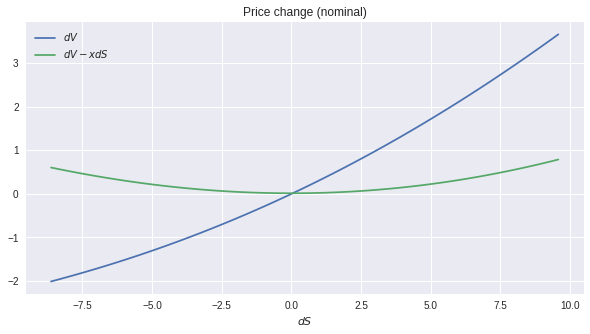

In [4]:
%matplotlib inline

# Numeric params setup
MC = 10000
dt = 5/365

# Market/Option params setup
r = 0.05
sig = 0.3
T = 1.
S0 = 70.
K = 90.
option = mibian.BS([S0, K, r*100, T*365], volatility = sig*100)

# Compute delta and price
delta = option.callDelta
V_0 = option.callPrice

# Simulate 1 day stock trajectory
S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]

# Make an array of likely stock prices, based on min-max of the simulation.
# Compute option prices on that array.
S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
V_1D = np.array([mibian.BS([S, K, r*100, T*365 - dt], volatility = sig*100).callPrice for S in S_1D])

# Compute price changes
DV_1D = V_1D - V_0*np.exp(r*dt)
DP_1D = (V_1D - delta*S_1D) - (V_0 - delta*S0)*np.exp(r*dt) 

# Plot changes of pure option vs portfolio
plt.figure(figsize=(10, 5))
plt.plot(S_1D - S0, DV_1D, label = '$dV$')
plt.plot(S_1D - S0, DP_1D, label = '$dV - xdS$')
plt.xlabel('$dS$')
plt.title('Price change (nominal)')
_ = plt.legend()

<div class="alert alert-block alert-info">
<b>Co tak właściwie się dzieje?</b>
    
$$ d\Pi = \bigg(\mu S \bigg(\frac{\partial V}{\partial S} - x \bigg)+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt + \sigma S \bigg(\frac{\partial V}{\partial S} - x \bigg)dW $$

Dobierając $x = \frac{\partial V}{\partial S}$ dostajemy dynamikę portfela:

$$ d\Pi = \bigg(\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt $$.   
</div>


A pisząc to samo po grecku:

Dobierając $x = \Delta$ dostajemy dynamikę portfela:

$$ d\Pi = \bigg(\frac{1}{2}\sigma^2 S^2 \Gamma + \Theta \bigg)dt $$

In [5]:
%matplotlib inline

@np.vectorize
def price_surface(S_, t_):
    return mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice

@np.vectorize
def price_surface_delta_hedged(S_, t_):
    option = mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    return option - delta*S_

S_lattice = np.linspace(S_1D.min(), S_1D.max(), 20)
t_lattice = np.linspace(0, dt, 20)

S, t = np.meshgrid(S_lattice, t_lattice)
V = price_surface(S, t)
Vh = price_surface_delta_hedged(S, t)

dV = V - V_0*np.exp(r*dt)
dVh = Vh - (V_0 - delta*S0)*np.exp(r*dt)

zmin, zmax = min(dVh.min(),dV.min()), max(dVh.max(), dV.max())

fig = go.Figure(data = [go.Surface(x=S-S0, y=t, z=dV, cmin=zmin, opacity=0.5, cmid=0.0, cmax = zmax, colorscale=colorscale),
                        go.Surface(x=S-S0, y=t, z=dVh, cmin=zmin, cmid=0.0, cmax = zmax, colorscale=colorscale)])
fig.update_layout(scene = dict(xaxis_title='dS',
                               yaxis_title='dt',
                               zaxis_title='dV'),
                autosize=False,
                margin=dict(l=0, r=0, b=0, t=50),
                title = "Unhedged vs Delta-hedged position")
fig.show()

## $\Delta-\Gamma$ hedging

Gammą instrumentu $V_t$ nazywamy $\Gamma := \frac{\partial^2 V}{\partial S^2}$. Jeżeli ta wartość również wyniesie zero, to portfel nazwiemy delta-gamma-neutralnym.

$$ d\Pi = \Big(\Theta +  \frac{1}{2}\sigma^2S^2\Gamma \Big)dt $$ 

$$ d\Pi = \Big(\Theta + 0 \Big)dt $$ 

Aby uzyskać portfel $\Delta$ neutralny musieliśmy posłużyć się innym, dodatkowym instrumentem finansowym. 
Okazuje się, że aby można uzyskać portfel jednocześnie $\Delta$ neutralny i $\Gamma$ neutralny ($\Delta-\Gamma$ neutralny), ale będziemy potrzebować do tego dwóch instrumentów.

Zajmiemy więc pozycję $x$ w akcji $S$, pozycję $y$ w opcji $C$, oraz sfinalizujemy to pozycją $z$ w obligacjach taką, żeby cały hedge był bezkosztowy:

$$ \Pi = V + x S + y C + z$$

$$ \Delta_{\Pi} = \Delta_{V} + x\Delta_{S} + y\Delta_{C} $$

$$ \Gamma_{\Pi} = \Gamma_{V} + x\Gamma_{S} + y\Gamma_{C} $$

Dobierzemy więc parę $(x, y)$ w sposób, który wyzeruje deltę i gammę pozycji. Aby je znaleźć rozwiązujemy układ równań:

$$\begin{bmatrix} \Delta_S & \Delta_C \\ \Gamma_S & \Gamma_C \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} -\Delta_{\Pi} \\ - \Gamma_{\Pi} \end{bmatrix}$$.

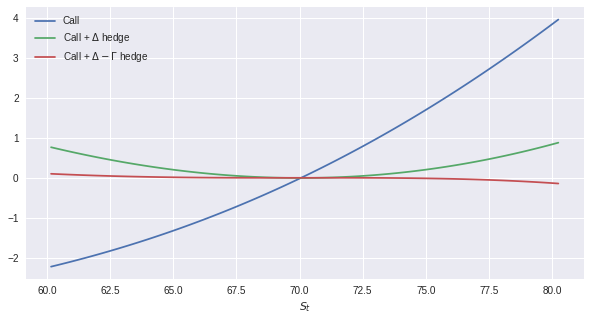

In [6]:
%matplotlib inline

# Setup two options
K1 = K
K2 = K1 + 30
option1 = mibian.BS([S0, K1, r*100, T*365], volatility = sig*100)
option2 = mibian.BS([S0, K2, r*100, T*365], volatility = sig*100)
options= [option1, option2]

# Calc their deltas, gammas and prices
deltas = [option.callDelta for option in options]
gammas = [option.gamma for option in options]
prices = [option.callPrice for option in options]

# Simulate 1D Stock prices, make an array covering their span and calculate option prices 
S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]
S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
prices_1D = [np.array([mibian.BS([S, k, r*100, 364], volatility = sig*100).callPrice for S in S_1D]) for k in [K1, K2]]

# Solve the linear system for (x,y)
# AX = B
A = np.array([[1.0, deltas[1]], [0.0 , gammas[1]]]) # 1.0 and 0.0 are S(t) delta and gamma
B = np.array([[-deltas[0]], [-gammas[0]]])
x, y = np.linalg.solve(A, B) # positions in S(t) and second option

DV_1D = prices_1D[0] - prices[0]*np.exp(r*dt)
DH_1D = (prices_1D[0] - deltas[0]*S_1D) - (prices[0] - deltas[0]*S0)*np.exp(r*dt)
DGH_1D = (prices_1D[0] + x*S_1D + y*prices_1D[1]) - (prices[0] + x*S0 + y*prices[1])*np.exp(r*dt)

plt.figure(figsize=(10, 5))
plt.plot(S_1D, DV_1D, label = 'Call')
plt.plot(S_1D, DH_1D, label = 'Call + $\Delta$ hedge')
plt.plot(S_1D, DGH_1D, label = 'Call + $\Delta-\Gamma$ hedge')

plt.xlabel('$S_t$')

_ = plt.legend()

In [7]:
%matplotlib notebook

@np.vectorize
def price_surface(S_, t_):
    return mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice

@np.vectorize
def price_surface_delta_gamma_hedged(S_, t_):
    option1 = mibian.BS([S_, K1, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    option2 = mibian.BS([S_, K2, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    return option1 + x*S_ + y*option2

S_lattice = np.linspace(S_1D.min(), S_1D.max(), 40)
t_lattice = np.linspace(0, dt, 20)

S, t = np.meshgrid(S_lattice, t_lattice)
V = price_surface(S, t)
Vdh = price_surface_delta_hedged(S, t)
Vdgh = price_surface_delta_gamma_hedged(S, t)

dV = V - prices[0]*np.exp(r*dt)
dVdh = Vdh - (prices[0] - delta*S0)*np.exp(r*dt)
dVdgh = Vdgh - (prices[0] + x*S0 + y*prices[1])*np.exp(r*dt)

zmin = min(dV.min(), dVdh.min(), dVdgh.min())
zmax = max(dV.max(), dVdh.max(), dVdgh.max())
zmid = (zmin + zmax)/2

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "scene"}, {"type": "scene"}]],
)

fig.add_trace(go.Surface(x=S-S0, y=t, z=dV, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=1)
fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=1)
fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdgh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=1)

fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=2)
fig.add_trace(go.Surface(x=S-S0, y=t, z=dVdgh, cmin=zmin, cmid=.0, cmax = zmax, colorscale=colorscale), row=1, col=2)

fig.update_layout(scene = dict(xaxis_title='dS',
                               yaxis_title='dt',
                               zaxis_title='dV'),
                autosize=False,
                margin=dict(l=0, r=0, b=0, t=50),
                width =1200,
                title = "Delta-hedged vs Delta-gamma hedged position")

fig.show()

## Dynamic hedging

Do tej pory rozważaliśmy jednodniowy przyrost. Zobaczmy jednak co dzieje się z zahedgowaną pozycją jeśli będziemy ją utrzymywać przez dłuzszy okres czasu

In [8]:
@np.vectorize
def option_delta(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration

    if option_type == "call":
      delta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).callDelta
    else:
      delta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).putDelta
    return delta

@np.vectorize
def option_gamma(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration
    gamma = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).gamma
    return gamma
    
@np.vectorize
def option_theta(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration
    if option_type == "call":
      theta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).callTheta
    else:
      theta = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).putTheta
    return theta
    
@np.vectorize
def option_vega(option_obj, option_type, S_, t_):
    S0 = option_obj.underlyingPrice
    K = option_obj.strikePrice
    sigma = option_obj.volatility
    r = option_obj.interestRate
    T = option_obj.daysToExpiration
    gamma = mibian.BS([S_, K, r*100, (T-t_)*365], volatility = sigma*100).vega
    return gamma


S0 = 100.
r = 0.05
sig = 0.3
T = 1.
K = 100

option = mibian.BS([S0, K, r*100, T*365], volatility = sigma)

S_lattice = np.linspace(S0*0.2, S0*1.7, 40)
t_lattice = np.linspace(0, T-0.01, 40)
S, t = np.meshgrid(S_lattice, t_lattice)
deltas = option_delta(option, "call", S, t)
gammas = option_gamma(option, "call", S, t)
thetas = option_theta(option, "call", S, t)
vegas = option_vega(option, "call", S, t)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Delta', 'Gamma', 'Theta', 'Vega'],
    specs=[[{"type": "scene"}, {"type": "scene"}],
           [{"type": "scene"}, {"type": "scene"}]])

fig.add_trace(go.Surface(x=S, y=t, z=deltas, colorscale="burgyl", showscale=False), row=1, col=1)
fig.add_trace(go.Surface(x=S, y=t, z=gammas, colorscale="viridis", cmin =-0.1*gammas.max() , cmid=gammas.max()*0.05, cmax=gammas.max()*0.6 , showscale=False), row=1, col=2)
fig.add_trace(go.Surface(x=S, y=t, z=thetas, colorscale="ylgnbu", showscale=False), row=2, col=1)
fig.add_trace(go.Surface(x=S, y=t, z=vegas, colorscale="purpor", showscale=False), row=2, col=2)

fig.update_layout(autosize=False,
                  margin=dict(l=0.1, r=0.1, t=40, b=0.01),

                  width = 1200,
                  height = 1200)
fig.show()

In [30]:
app = JupyterDash(__name__)
height = 500
width = 600

df = pd.DataFrame.from_dict({'UnderlyingPrice': S.ravel(), 'TimeToExpiry': t.ravel(),
                             'CallDelta': deltas.ravel(), 'CallGamma': gammas.ravel(), 
                             'CallTheta': thetas.ravel(), 'CallVega': vegas.ravel()}, orient='columns')

deltas_figure = go.Figure(data=[go.Surface(x=S, y=t, z=deltas)], layout=layout)

app.layout = html.Div(
    children=[
        html.H2(
            "Call Greeks visualization "
        ),
        html.Div(
            [
                html.Div(
                    dcc.Graph(figure=deltas_figure),
                    style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    dcc.Graph(figure=px.scatter_3d(df, y="UnderlyingPrice", x="TimeToExpiry", z='CallGamma',
                                                   color='CallGamma', color_continuous_scale='rdbu',
                                                   title='CallGamma', # opacity=0.8,
                                                   template="ggplot2",
                                                   height=height,
                                                   width=width)),
                         style={"width": "49%", "display": "inline-block"},
                ),
            ]
        ),
        html.Div(
            [
                html.Div(
                    dcc.Graph(figure=px.scatter_3d(df, y="UnderlyingPrice", x="TimeToExpiry", z='CallTheta',
                                                   color='CallTheta', color_continuous_scale='rdbu',
                                                   title='CallTheta', # opacity=0.8,
                                                   template="ggplot2",
                                                   height=height,
                                                   width=width)),
                         style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    dcc.Graph(figure=px.scatter_3d(df, y="UnderlyingPrice", x="TimeToExpiry", z='CallVega',
                                                   color='CallVega', color_continuous_scale='rdbu',
                                                   title='CallVega', # opacity=0.8,
                                                   template="ggplot2",
                                                   height=height,
                                                   width=width)),
                         style={"width": "49%", "display": "inline-block"},
                ),
            ]
        ),
    ]
)

app.run_server(
    mode="inline",
    port=8070,
    dev_tools_ui=True,
    debug=True,
    dev_tools_hot_reload=True,
    threaded=True,
)

<IPython.core.display.Javascript object>

Rozwiązaniem może być dynamiczne rebalansowanie pozycji - np. codziennie, co kilka dni, czy co tydzień etc.
Pojawia się tu inny problem, bo im częściej rebalansujemy tym większe koszty transakcji ponosimy. W praktyce należy dobrać pewien trade-off między częstością rebalansowania, a jego kosztami. 

Żeby doczytać więcej na ten temat sprawdź:
* [Ten artykuł](https://www.efmaefm.org/0efmameetings/efma%20annual%20meetings/2005-Milan/papers/284-zakamouline_paper.pdf) bazujący na funkcji użyteczności
* [Trochę nowocześniejsze podejście...](https://arxiv.org/pdf/1802.03042.pdf) używające RNN ...
* [... i jego kontynuacja](https://arxiv.org/pdf/2109.12337.pdf) porównująca modele liniowe, ML i CNN.

My założymy dla uproszczenia, że kosztów transakcji nie ma i skupimy się na mechanice dynamicznego rebalansowania pozycji.

Będziemy wykonywać następujące kroki:
1. Zadamy parametry opcji, oraz rynku
2. Wyliczymy deltę, gammę i pozycje hedgujące portfel
3. Dohedgujemy/odhedgujemy pozycję w sposób bezkosztowy
4. Wysymulujemy "krok" instrumentu bazowego
5. Obliczymy nową wartość portfela zgodnie z 2. i 3.
6. Wrócimy do punktu 2.

In [ ]:
option.__dict__

In [ ]:
option.strikePrice

In [ ]:
def dynamic_hedging(stock_trajectory, option_to_hedge, option_for_gamma):
    
    gbm_traj = stock_trajectory
    K = option_to_hedge.strikePrice
    r = option_to_hedge.interestRate
    T1 = option_to_hedge.daysToExpiration
    sig = option_to_hedge.volatility
    
    K2 = option_for_gamma.strikePrice
    T2 = option_for_gamma.daysToExpiration
    
    t_axis = np.linspace(0, T1, len(gbm_traj))
    dt = t_axis[1] - t_axis[0]


    Vt = []
    St = []
    Ct = []
    t=[]

    Strategies = {'DeltaHedge': {"t": [],
                                 "Value": [],
                                 "Stock": [],
                                 "MM": []},
                  'DeltaGammaHedge': {"t": [],
                                      "Value": [],
                                      "Stock": [],
                                      "Option": [],
                                      "MM":[]}
                 }
    for S, t_ in zip(gbm_traj[:-1], t_axis[:-1]):
        
        option_V = mibian.BS([S, K, r*100, (T1-t_)*365], volatility = sig*100)
        option_C = mibian.BS([S, K2, r*100, (T2-t_)*365], volatility = sig*100)
        
        V = option_V.callPrice
        C = option_C.callPrice
        S = S

        if t_ == 0:
            DH = 0.0 # current value of delta hedged portfolio "hedge" part
            DGH = 0.0 # current value of delta-gamma hedged portfolio "hedge" part
        else:
            DH = Strategies['DeltaHedge']['Stock'][-1]*S + Strategies['DeltaHedge']['MM'][-1]*np.exp(r*dt)
            DGH = Strategies['DeltaGammaHedge']['Stock'][-1]*S + Strategies['DeltaGammaHedge']['Option'][-1]*C + Strategies['DeltaGammaHedge']['MM'][-1]*np.exp(r*dt)

        Strategies['DeltaHedge']['Value'].append(DH)
        Strategies['DeltaGammaHedge']['Value'].append(DGH)

        Vt.append(V)
        St.append(S)
        Ct.append(C)
        t.append(t_)

        # Greeks
        delta_V = option_V.callDelta
        delta_C = option_C.callDelta
        delta_S = 1.0

        gamma_V = option_V.gamma
        gamma_C = option_C.gamma
        gamma_S = 0.0
        #Pdb().set_trace()

        # Delta hedging
        A = np.array([[delta_S, 0], [S, 1]])
        B = np.array([[delta_V], [DH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaHedge']['MM'].append(X[1][0])

        #Delta-gamma hedging
        A = np.array([[delta_S, delta_C, 0], [gamma_S, gamma_C, 0], [S, C, 1]])
        B = np.array([[delta_V], [gamma_V], [DGH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaGammaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaGammaHedge']['Option'].append(X[1][0])
        Strategies['DeltaGammaHedge']['MM'].append(X[2][0])


    t = np.array(t).reshape(-1, 1)
    Vt = np.array(Vt).reshape(-1, 1)
    Strategies['DeltaHedge']['Value'] = np.array(Strategies['DeltaHedge']['Value']).reshape(-1, 1)
    Strategies['DeltaGammaHedge']['Value'] = np.array(Strategies['DeltaGammaHedge']['Value']).reshape(-1, 1)
    
    return t, Vt, Strategies 


S0 = 60.
r = .05
sig = .3
T = 365. # days

gbm_traj = gbm(S0 = S0, r = r, sigma = sig, T = T/365, time_steps = 252, n_paths = 1).ravel()


option_to_hedge = mibian.BS([S0, 60., r*100, T], volatility = sig*100)
option_for_gamma = mibian.BS([S0, 65., r*100, T], volatility = sig*100)

t, Vt, Strategies = dynamic_hedging(gbm_traj, option_to_hedge = option_to_hedge, option_for_gamma = option_for_gamma)

In [ ]:
%matplotlib inline 
plt.plot(t, gbm_traj[1:])

In [ ]:
%matplotlib notebook
plt.plot(t[1:], Vt[1:], label = 'Position')
plt.plot(t[1:], -Strategies['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t[1:], Vt[1:] - Strategies['DeltaHedge']['Value'][1:], "Delta hedged position")

In [ ]:
%matplotlib notebook
plt.plot(t[1:], Vt[1:], label = 'Position')
plt.plot(t[1:], -Strategies['DeltaGammaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t[1:], Vt[1:] - Strategies['DeltaGammaHedge']['Value'][1:], "Delta-gamma hedged position")

In [ ]:
diff = (Vt[1:] - Strategies['DeltaGammaHedge']['Value'][1:])
np.log(diff[-1]/diff[0])

# Przykład na danych rynkowych

In [ ]:
ticker = "MSFT"
real_data = yf.download(ticker, start="2019-10-01", end="2020-10-01")['Open']
calibration_data = yf.download(ticker, start = "2018-10-01", end="2019-10-01")["Open"]

In [ ]:
%matplotlib inline
real_data.plot(label="Testing")
calibration_data.plot(label="Calibration")

plt.legend()
_ = plt.title(f"{ticker} stock price")

In [ ]:
S0 = real_data[0]
sig_hist = np.log(calibration_data).diff().mean()*np.sqrt(365)
t_real, Vt_real, Strategies_real = dynamic_hedging(real_data,
                                                   option_to_hedge = mibian.BS([S0, 190, r*100, 365], volatility = sig_hist*100),
                                                   option_for_gamma = mibian.BS([S0, 200, r*100, 2*365], volatility = sig_hist*100))

In [ ]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], -Strategies_real['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaHedge']['Value'][1:], "Delta hedged position")

In [ ]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], -Strategies_real['DeltaGammaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaGammaHedge']['Value'][1:], "Delta-gamma hedged position")

In [ ]:
%matplotlib inline
real_data_np = np.array(real_data).reshape(-1, 1)
logrets_real = np.diff(np.log(real_data_np), axis = 0)
plt.hist(logrets_real, label = f'{ticker} logreturns', bins = 20)

logrets_gbm = np.diff(np.log(gbm_traj))
plt.hist(logrets_gbm, label = 'GBM logreturns', bins = 20)
plt.legend()

In [ ]:
plt.style.use('default')
t_fitted = sc.t.fit(logrets_real)
t_fitted = sc.t(*t_fitted)

norm_fitted = sc.norm.fit(logrets_real)
norm_fitted = sc.norm(*norm_fitted)

cauchy_fitted = sc.cauchy.fit(logrets_real)
cauchy_fitted = sc.cauchy(*cauchy_fitted)

x_axis = np.linspace(logrets_real.min(), logrets_real.max(), 100)
_=plt.hist(logrets_real, label =f'{ticker} logreturns', bins = 20, density = True)
plt.plot(x_axis, t_fitted.pdf(x_axis), label = 'Fitted t distribution')
plt.plot(x_axis, norm_fitted.pdf(x_axis), label = 'Fitted normal distribution')
_= plt.legend()

In [ ]:
%matplotlib inline
plt.style.use('default')
t_params = sc.t.fit((logrets_real - logrets_real.mean())/logrets_real.std())
t_fit = sc.t(*t_params)

St = gbm(S0 = 100, r = 0.01, sigma = 0.3, T = 1, time_steps=252, n_paths = 1, random_generator = t_fit)
logrets_sim = np.diff(np.log(St), axis = 0)

x_axis = np.linspace(logrets_real.min(), logrets_real.max(), 100)
_ = plt.hist(logrets_sim, label ='Simulated logreturns', bins = 30, density = True, alpha = 0.5)
_ = plt.hist(logrets_real, label ='Real logreturns', bins = 30, density = True, alpha = 0.5)

_ = plt.legend()

In [ ]:
def price_MC(stock_trajectory, strike, r, T, option_type):
    
    ST = stock_trajectory[-1, :]
    if option_type == 'CALL':
        payoff = np.maximum(ST - strike, 0).mean()
    else:
        payoff = np.maximum(strike - ST, 0).mean()
    
    return payoff*np.exp(-r*T)

def dynamic_hedging2(stock_trajectory, random_generator, option_to_hedge, option_for_gamma):
    
    gbm_traj = stock_trajectory
    option_type, K = option_to_hedge
    option_type2, K2 = option_for_gamma
    
    t_axis = np.linspace(0, T, len(gbm_traj))
    dt = t_axis[1] - t_axis[0]


    Vt = []
    St = []
    Ct = []
    t=[]

    Strategies = {'DeltaHedge': {"t": [],
                                 "Value": [],
                                 "Stock": [],
                                 "MM": []},
                  'DeltaGammaHedge': {"t": [],
                                      "Value": [],
                                      "Stock": [],
                                      "Option": [],
                                      "MM":[]}
                 }
    for ind, (S, t_) in enumerate(zip(gbm_traj[:-10], t_axis[:-10])):
        K = S*0.9
        K2 = S*1.1
        
        V = vanilla_price(S, K, option_type, r, sig, T-t_)
        C = vanilla_price(S, K2, option_type2, r, sig, T-t_)
        S = S

        if t_ == 0:
            DH = 0.0
            DGH = 0.0
        else:
            DH = Strategies['DeltaHedge']['Stock'][-1]*S + Strategies['DeltaHedge']['MM'][-1]*np.exp(r*dt)
            DGH = Strategies['DeltaGammaHedge']['Stock'][-1]*S + Strategies['DeltaGammaHedge']['Option'][-1]*C + Strategies['DeltaGammaHedge']['MM'][-1]*np.exp(r*dt)

        Strategies['DeltaHedge']['Value'].append(DH)
        Strategies['DeltaGammaHedge']['Value'].append(DGH)

        Vt.append(V)
        St.append(S)
        Ct.append(C)
        t.append(t_)
        
        epsilon = 0.000001
        S_plus = S*(1+epsilon)
        S_minus = S*(1-epsilon)
        dS = S_plus - S_minus
        
        simu_S = gbm(S0 = S, r = 0.01, sigma = 0.3, T = T-t_, time_steps=len(gbm_traj[:-10])-ind, n_paths = 200000, 
                     random_generator = random_generator)
        simu_S_plus = simu_S*(1+epsilon)
        simu_S_minus = simu_S*(1-epsilon)
        
        
        # Greeks
        delta_V = (price_MC(simu_S_plus, K, r, T, option_type) - 
                   price_MC(simu_S_minus, K, r, T, option_type))/(2*dS)
        delta_C = (price_MC(simu_S_plus, K2, r, T, option_type) -
                   price_MC(simu_S_minus, K2, r, T, option_type))/(2*dS)
        delta_S = 1.0

        
        gamma_V = (price_MC(simu_S_plus, K, r, T, option_type) - 
                   2*price_MC(simu_S, K, r, T, option_type) + 
                   price_MC(simu_S_minus, K, r, T, option_type))/(dS**2)
        gamma_C = (price_MC(simu_S_plus, K2, r, T, option_type2) - 
                   2*price_MC(simu_S, K2, r, T, option_type2) + 
                   price_MC(simu_S_minus, K2, r, T, option_type2))/(dS**2)
        gamma_S = 0.0

        print(f"S_{t_:.2f} = {S:.4f}: delta_V = {delta_V:.4f}, delta_C = {delta_C:.4f}, gamma_V = {gamma_V:.4f}, gamma_C = {gamma_C:.4f}")
        # Delta hedging
        A = np.array([[delta_S, 0], [S, 1]])
        B = np.array([[delta_V], [DH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaHedge']['MM'].append(X[1][0])

        #Delta-gamma hedging
        A = np.array([[delta_S, delta_C, 0], [gamma_S, gamma_C, 0], [S, C, 1]])
        B = np.array([[delta_V], [gamma_V], [DGH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaGammaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaGammaHedge']['Option'].append(X[1][0])
        Strategies['DeltaGammaHedge']['MM'].append(X[2][0])

    t = np.array(t).reshape(-1, 1)
    Vt = np.array(Vt).reshape(-1, 1)
    Strategies['DeltaHedge']['Value'] = np.array(Strategies['DeltaHedge']['Value']).reshape(-1, 1)
    Strategies['DeltaGammaHedge']['Value'] = np.array(Strategies['DeltaGammaHedge']['Value']).reshape(-1, 1)
    
    return t, Vt, Strategies 

In [ ]:
t_real, Vt_real, Strategies_real = dynamic_hedging2(real_data, random_generator = t_fit, option_to_hedge = ('CALL', 100), option_for_gamma = ('CALL', 90))

In [ ]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], Strategies_real['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaHedge']['Value'][1:], "Delta hedged position")